# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

##### ❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?



Nuance:
Q&D Pairs: Directly optimize for question-answering retrieval by making question embeddings similar to their answer-document embeddings.
Inter-document/Related Sentences: Improve general semantic understanding within a domain by making related texts similar, but less directly optimized for specific Q&A retrieval.  
  
Caveats (Q&D with synthetic generation):
Effectiveness depends on the quality of synthetic questions.
Risk of overfitting to the style of synthetic questions, potentially harming generalization.
Generated questions might not cover all types of real user queries.  
  
    
    
Considerations for Q's:
Should mimic real user queries in style and complexity.
Include diverse question types (factual, descriptive).
Must be answerable only from the provided context chunk.

## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [2]:
!pip install -qU "langchain_openai>=0.3.4" "langchain_huggingface" "langchain_core>=0.3.34" "langchain>=0.3.18" "langchain_community>=0.3.17" "langchain-text-splitters>=0.3.6" "datasets>=3.2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/

In [3]:
!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 16.3 MB/s eta 0:00:00


### Provide OpenAI API Key

In [4]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31537    0 31537    0     0  66776      0 --:--:-- --:--:-- --:--:-- 66815


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70721    0 70721    0     0   689k      0 --:--:-- --:--:-- --:--:--  690k


In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

> NOTE: You may need to run this cell twice to get it to work.

In [10]:
training_documents = text_splitter.split_documents(text_loader.load())

In [11]:
len(training_documents)

102

Next, we're going to associate each of our chunks with a unique identifier.

In [12]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [13]:
training_split_documents = training_documents[:len(training_documents) - 24]
val_split_documents = training_documents[len(training_documents) - 24:102-12]
test_split_documents = training_documents[102-12:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4.1-mini`

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [14]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [15]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [16]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [17]:
import tqdm
import asyncio

"""
Sample Usage of TQDM:

for i in tqdm.tqdm(range(10)):
  time.sleep(1)
"""

async def create_questions(documents, n_questions):
    questions = {}
    relevant_docs = {}

    for doc in tqdm.tqdm(documents, desc="Generating questions"):
        # Prepare the input for the chain
        input_context = doc.page_content
        doc_id = doc.metadata["id"]

        # Call the question generation chain
        response = await question_generation_chain.ainvoke({"context": input_context, "n_questions": n_questions})

        # Extract questions
        generated_questions = response.content.split("\n")
        generated_questions = [q.strip() for q in generated_questions if q.strip()]

        # Some outputs might be numbered like "1. What is ...?", so clean numbering
        cleaned_questions = []
        for q in generated_questions:
            if q[0].isdigit() and q[1] == '.':
                cleaned_questions.append(q[2:].strip())
            elif q[0].isdigit() and q[1] == ' ':
                cleaned_questions.append(q[1:].strip())
            else:
                cleaned_questions.append(q)

        # Now save each question
        for q in cleaned_questions:
            question_id = str(uuid.uuid4())
            questions[question_id] = q
            relevant_docs[question_id] = [doc_id]

    return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [18]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Generating questions: 100%|██████████| 78/78 [02:17<00:00,  1.76s/it]


We'll use the function to generate training, validation, and test data.

In [19]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Generating questions: 100%|██████████| 12/12 [00:19<00:00,  1.60s/it]


In [20]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Generating questions: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [21]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [22]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [23]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [24]:
!pip install -qU sentence_transformers pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 55.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.


In [25]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [26]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [27]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [28]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [29]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [30]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

MultipleNegativesRankingLoss (MNRL):  
Purpose: Trains embedding models for retrieval.  
Function: Pushes a query embedding closer to its relevant document embedding and further from irrelevant ("negative") document embeddings, often using other documents in the same batch as negatives. It directly optimizes ranking.  
  

MatryoshkaLoss:  
Purpose: Enables efficient use of embeddings at varying dimensions.  
Function: A wrapper loss that trains embeddings so that the full-dimension embedding, as well as its shorter prefixes (e.g., the first 512 or 256 dimensions of a 768-dim embedding), are also effective. This allows for deploying smaller, faster versions of the model without retraining.

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [31]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [32]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [33]:
import wandb
wandb.init(mode="disabled")

> NOTE: You may not see direct improvement during the training cycles - this is absolutely expected. We will verify performance later in the notebook.

In [34]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
16,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.963789,0.951389,0.951389
32,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
48,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
50,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
64,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
80,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
96,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
100,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.953866,0.937500,0.937500
112,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
128,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333


In [35]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
hf_username = "s4um1l"

In [37]:
import uuid

model.push_to_hub(f"{hf_username}/legal-ft-{uuid.uuid4()}")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/s4um1l/legal-ft-99362bf0-00be-40f1-9bcf-89707ef842b1/commit/e97dad0b47b2edc02a7b6544c99f6e94b3d76b5c'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [38]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [39]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [40]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 24/24 [00:11<00:00,  2.18it/s]


In [41]:
te3_results_df = pd.DataFrame(te3_results)

In [42]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(1.0)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [43]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 24/24 [00:00<00:00, 44.68it/s]


In [44]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [45]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.9166666666666666)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [46]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic_ft")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic_ft and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 24/24 [00:00<00:00, 44.92it/s]


In [47]:
finetune_results_df = pd.DataFrame(finetune_results)

In [48]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(1.0)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [50]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [51]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [52]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [53]:
rag_llm =  ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [54]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [55]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'Based on the provided context, an "agent" in the context of AI refers to systems that are often described as capable of acting on your behalf, such as travel agents or digital assistants. However, the term is highly vague and lacks a clear, widely accepted definition. The discussions highlight that many people use the term differently—some see agents as systems that can go and act independently, while others think of them as LLMs with access to tools that can be used iteratively to solve problems. Despite the excitement, the concept remains somewhat elusive, and there is skepticism about their current utility due to issues like gullibility and the difficulty in distinguishing truth from fiction.'

In [56]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Several organizations have produced models that are better than GPT-3, including Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, and Baidu.'

In [57]:
base_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context does not specify a particular time of year that is considered the "laziest" for AI.'

In [58]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The provided context does not specify the name Simon or detail the largest model he has run on his phone.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [59]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [60]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [61]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'An agent, in the context of AI and large language models, is a term that lacks a clear, universally agreed-upon definition. It generally refers to systems that act on your behalf, such as travel agents or digital assistants, or to LLMs that have been given access to tools and can operate in loops to solve problems. However, the term is often used vaguely, and there is skepticism about their current utility due to issues like gullibility and the inability to reliably distinguish truth from fiction. Overall, an agent is a concept that is still evolving and not precisely defined.'

In [62]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Several organizations, including Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII (Abu Dhabi), Microsoft Research, xAI, Replit, Baidu, and others, have produced models that are better than GPT-3.'

In [63]:
finetune_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'I do not know.'

In [64]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The largest model that Simon has run on his phone is Llama 3.2 3B.'

#### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

he fine-tuned RAG chain performed better.

Why: It provided a more specific and accurate answer to the question, "What is the largest model that Simon has run on his phone?" (answered "Llama 3.2 3B"), while the base RAG chain could not extract this detail. For other questions, their performance was comparable.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [79]:
!pip install ragas


In [80]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader, BSHTMLLoader

# Reload if necessary or reuse 'loaded_documents_for_ft'
path = "data/"
ragas_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader, show_progress=True)
ragas_docs = ragas_loader.load()

# Use RAGAS notebook splitter config
ragas_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
ragas_split_documents = ragas_text_splitter.split_documents(ragas_docs)
print(f"Split into {len(ragas_split_documents)} chunks for RAG evaluation.")

100%|██████████| 2/2 [00:00<00:00, 60.77it/s]

Split into 79 chunks for RAG evaluation.


In [81]:
!pip install rapidfuzz

In [82]:
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Ensure API key is set
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

ragas_generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano")) # Or gpt-4o
ragas_generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

ragas_test_generator = TestsetGenerator(llm=ragas_generator_llm, embedding_model=ragas_generator_embeddings)

# Generate the testset based on the RAGAS-specific document splits
# Using langchain Documents directly
ragas_evaluation_dataset_gen = ragas_test_generator.generate_with_langchain_docs(ragas_split_documents, testset_size=10)
ragas_eval_df = ragas_evaluation_dataset_gen.to_pandas()
print("RAGAS evaluation dataset generated.")
display(ragas_eval_df.head())

Applying SummaryExtractor:   0%|          | 0/73 [00:00<?, ?it/s]

ERROR:ragas.testset.transforms.engine:unable to apply transformation: Invalid json output: The GPT-4 barrier has been broken, with some models running on personal laptops. LLM prices have dropped due to increased competition and efficiency. Multimodal capabilities like vision, audio, and video are becoming common, and voice and live camera features are now a reality. Prompt-driven app generation is widespread. Universal access to top models was short-lived, and true agents are still emerging. Evaluation processes are increasingly important. Apple's MLX library outperforms its own intelligence. Inference-scaling models are rising, and some of the best LLMs were trained in China for less than $6 million. Environmental impacts have fluctuated, with some improvements and some worsening. Synthetic training data proves effective, but LLM usability remains challenging. Knowledge distribution is uneven, highlighting the need for better critique of LLMs.
For troubleshooting, visit: https://pyth

Applying CustomNodeFilter:   0%|          | 0/79 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/228 [00:00<?, ?it/s]

ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: The LLM generation was not completed. Please increase the max_tokens and try again.


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.testset.transforms.engine:unable to apply transformation: Node 0b4af573-1c4a-49ec-8e69-529bd7df8316 has no summary_embedding
ERROR:ragas.testset.transforms.engine:unable to apply transformation: Node 957e3fba-07ab-440a-9c1b-a59c17e37644 or cafd5139-ec92-47cb-bcd2-e387391ecafd has no entities


Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

RAGAS evaluation dataset generated.


,user_input,reference_contexts,reference,synthesizer_name
0,What are some key insights about LLMs learned ...,[Things we learned about LLMs in 2024\n\n\n\n\...,"In 2024, a lot has happened in the world of La...",single_hop_specifc_query_synthesizer
1,What are the concerns related to Apple Intelli...,[The GPT-4 barrier was comprehensively broken\...,The context states that Apple Intelligence is ...,single_hop_specifc_query_synthesizer
2,Can you explain how the GPT-4 barrier was brok...,[The GPT-4 barrier was comprehensively broken\...,"The GPT-4 barrier was comprehensively broken, ...",single_hop_specifc_query_synthesizer
3,What is the significance of 2024 in AI develop...,[The earliest of those was Google’s Gemini 1.5...,The context highlights that 2024 is a key year...,single_hop_specifc_query_synthesizer
4,Considering the environmental implications of ...,[Longer inputs dramatically increase the scope...,The provided context discusses various large l...,single_hop_specifc_query_synthesizer


In [83]:
from langchain_huggingface import HuggingFaceEmbeddings

# Base Model
base_model_name = "Snowflake/snowflake-arctic-embed-l"
base_embeddings_ragas = HuggingFaceEmbeddings(model_name=base_model_name)

# Fine-tuned Model (ensure path is correct)
finetuned_model_path = "finetuned_arctic_ft"
try:
    finetune_embeddings_ragas = HuggingFaceEmbeddings(model_name=finetuned_model_path)
except Exception as e:
    print(f"Error loading fine-tuned model from {finetuned_model_path}: {e}")
    print("Ensure the fine-tuning step completed successfully and the path is correct.")
    # Assign base model as fallback or raise error
    finetune_embeddings_ragas = base_embeddings_ragas

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic_ft and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
from langchain_community.vectorstores import FAISS

# Build Base Vector Store
print("Building Base Vector Store...")
base_vectorstore_ragas = FAISS.from_documents(ragas_split_documents, base_embeddings_ragas)
base_retriever_ragas = base_vectorstore_ragas.as_retriever(search_kwargs={"k": 5})

# Build Fine-tuned Vector Store
print("Building Fine-tuned Vector Store...")
finetune_vectorstore_ragas = FAISS.from_documents(ragas_split_documents, finetune_embeddings_ragas)
finetune_retriever_ragas = finetune_vectorstore_ragas.as_retriever(search_kwargs={"k": 5})

Building Base Vector Store...
Building Fine-tuned Vector Store...


In [85]:

from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document # Needed for type hint
import time # For potential debugging delays

def format_docs(docs: list[Document]) -> str:
    """Helper to format retrieved documents for the prompt."""
    if not docs or not isinstance(docs, list):
        return "No context provided."
    return "\\n\\n".join(doc.page_content for doc in docs if hasattr(doc, 'page_content'))

def create_rag_chain_for_eval(retriever, llm):
    """Creates a RAG chain that returns question, contexts, and answer, robustly."""

    # Define prompt
    RAG_PROMPT_RAGAS = """You are a helpful assistant answering questions based *only* on the provided context.
If the context does not contain the answer, say exactly "I cannot answer the question based on the provided context."

Context:
{context}

Question:
{question}

Answer:"""
    prompt = ChatPromptTemplate.from_template(RAG_PROMPT_RAGAS)

    # --- Define Chain Steps More Explicitly ---

    # Step 1: Retrieve documents, keeping the question
    # Input: {'question': '...'}
    step1_retrieve = RunnableParallel(
           docs=itemgetter("question") | retriever,
           question=itemgetter("question") # Pass question along
    )
    # Output: {'question': '...', 'docs': [Doc]}

    # Step 2: Format context string, keeping previous results
    # Input: {'question': '...', 'docs': [Doc]}
    step2_format_context = RunnablePassthrough.assign(
        context_str = itemgetter("docs") | RunnableLambda(format_docs)
    )
    # Output: {'question': '...', 'docs': [Doc], 'context_str': '...'}

    # Step 3: Generate Answer, keeping previous results
    # Input: {'question': '...', 'docs': [Doc], 'context_str': '...'}
    step3_generate_answer = RunnablePassthrough.assign(
        answer = {
            "context": itemgetter("context_str"),
            "question": itemgetter("question")
        } | prompt | llm | StrOutputParser()
    )
    # Output: {'question': '...', 'docs': [Doc], 'context_str': '...', 'answer': '...'}


    # Step 4: Format final output dictionary for RAGAS
    # Input: {'question': '...', 'docs': [Doc], 'context_str': '...', 'answer': '...'}
    step4_format_output = RunnableLambda(lambda x: {
            "question": x.get("question", "N/A"),
            "contexts": [doc.page_content for doc in x.get("docs", []) if hasattr(doc, 'page_content')],
            "answer": x.get("answer", "Error: No answer generated")
    })
    # Output: {'question': '...', 'contexts': [...], 'answer': '...'}

    # --- Combine Chain Steps Sequentially ---
    rag_chain = step1_retrieve | step2_format_context | step3_generate_answer | step4_format_output

    return rag_chain

rag_llm_ragas = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [86]:
base_rag_chain_ragas = create_rag_chain_for_eval(base_retriever_ragas, rag_llm_ragas)
finetune_rag_chain_ragas = create_rag_chain_for_eval(finetune_retriever_ragas, rag_llm_ragas)


In [87]:

from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI # Make sure rag_llm_ragas is defined
from langchain_core.documents import Document
import traceback

print("--- Starting Debug Run ---")

# --- 1. Define the Failing Question ---
# Choose one question that consistently shows the error in your log
failing_question = "What is GPT-3 and how does it relate to the recent..."
print(f"Debugging for question: '{failing_question}'")

# --- 2. Select Retriever and LLM to Debug ---
# Use either the base or fine-tuned retriever/chain that was failing
# Make sure these variables (e.g., base_retriever_ragas, rag_llm_ragas) exist from previous cells!
try:
    retriever_to_debug = base_retriever_ragas # Or finetune_retriever_ragas
    llm_to_debug = rag_llm_ragas
    if not retriever_to_debug or not llm_to_debug:
         raise NameError("Retriever or LLM for debugging is not defined.")
    print("Using Base Retriever for debugging.") # Change if debugging fine-tuned
except NameError as ne:
    print(f"Error: Required components not defined. Make sure previous cells ran successfully. Details: {ne}")
    # Stop execution if components missing
    raise SystemExit("Stopping debug run due to missing components.")


# --- 3. Re-Define Chain Steps Individually ---
# (Copying the logic from the corrected create_rag_chain_for_eval)

# Helper function
def format_docs(docs: list[Document]) -> str:
    if not docs or not isinstance(docs, list):
        return "No context provided."
    return "\\n\\n".join(doc.page_content for doc in docs if hasattr(doc, 'page_content'))

# Step 1: Retrieve documents, keeping the question
step1_retrieve = RunnableParallel(
       docs=itemgetter("question") | retriever_to_debug,
       question=itemgetter("question")
)

# Step 2: Format context string, keeping previous results
step2_format_context = RunnablePassthrough.assign(
    context_str = itemgetter("docs") | RunnableLambda(format_docs)
)

# Step 3 Sub-Chain: The part that generates the answer string
answer_generation_subchain = (
     RunnableParallel(
         context=itemgetter("context_str"),
         question=itemgetter("question")
     )
     | ChatPromptTemplate.from_template("""You are a helpful assistant answering questions based *only* on the provided context.If the context does not contain the answer, say exactly "I cannot answer the question based on the provided context.

Context:
{context}

Question:
{question}

Answer:""")
| llm_to_debug
| StrOutputParser()
)

# Step 3: Generate Answer, keeping previous results
step3_generate_answer = RunnablePassthrough.assign(
    answer = answer_generation_subchain
)

# Step 4: Format final output dictionary for RAGAS
step4_format_output = RunnableLambda(lambda x: {
        "question": x.get("question", "N/A"),
        "contexts": [doc.page_content for doc in x.get("docs", []) if hasattr(doc, 'page_content')],
        "answer": x.get("answer", "Error: No answer generated")
})

# --- 4. Execute Step-by-Step ---
print("\n--- Executing Steps ---")
input_data = {"question": failing_question}
print(f"Input: {input_data}\n")

output_step1 = None
output_step2 = None
output_step3 = None
output_step4 = None

try:
    # --- Run Step 1 ---
    print("Running Step 1 (retrieve)...")
    output_step1 = step1_retrieve.invoke(input_data)
    print(f"Output Step 1 Type: {type(output_step1)}")
    if isinstance(output_step1, dict):
        print(f"Output Step 1 Keys: {output_step1.keys()}")
        print(f"Output Step 1 'docs' Type: {type(output_step1.get('docs'))}")
        # print(output_step1) # Uncomment carefully, can be large
    else:
        print(f"Output Step 1 Unexpected Content: {str(output_step1)[:500]}") # Print start if not dict
    assert isinstance(output_step1, dict), "Output of Step 1 is not a dict!"
    print("Step 1 OK.\n")

    # --- Run Step 2 ---
    print("Running Step 2 (format_context)...")
    output_step2 = step2_format_context.invoke(output_step1)
    print(f"Output Step 2 Type: {type(output_step2)}")
    if isinstance(output_step2, dict):
        print(f"Output Step 2 Keys: {output_step2.keys()}")
        print(f"Output Step 2 'context_str' Type: {type(output_step2.get('context_str'))}")
        # print(output_step2) # Uncomment carefully
    else:
        print(f"Output Step 2 Unexpected Content: {str(output_step2)[:500]}")
    assert isinstance(output_step2, dict), "Output of Step 2 is not a dict!"
    print("Step 2 OK.\n")

    # --- Run Step 3 ---
    print("Running Step 3 (generate_answer)...")
    output_step3 = step3_generate_answer.invoke(output_step2)
    print(f"Output Step 3 Type: {type(output_step3)}")
    if isinstance(output_step3, dict):
        print(f"Output Step 3 Keys: {output_step3.keys()}")
        print(f"Output Step 3 'answer' Type: {type(output_step3.get('answer'))}")
        # print(output_step3) # Uncomment carefully
    else:
        print(f"Output Step 3 Unexpected Content: {str(output_step3)[:500]}")
    assert isinstance(output_step3, dict), "Output of Step 3 is not a dict!"
    print("Step 3 OK.\n")

    # --- Run Step 4 ---
    print("Running Step 4 (format_output)...")
    output_step4 = step4_format_output.invoke(output_step3)
    print(f"Output Step 4 Type: {type(output_step4)}")
    print(f"Final Output (RAGAS format):")
    print(output_step4)
    assert isinstance(output_step4, dict), "Output of Step 4 is not a dict!"
    print("Step 4 OK.\n")

    print("--- Debugging Run Completed Successfully ---")

except Exception as e:
    print(f"\n--- ERROR occurred during debugging run ---")
    print(f"Error Type: {type(e)}")
    print(f"Error Message: {e}")
    print("\n--- Traceback ---")
    traceback.print_exc()
    print("\n--- Last Successful Output ---")
    if output_step3 is not None:
         print("Output Step 3 was:", output_step3)
    elif output_step2 is not None:
         print("Output Step 2 was:", output_step2)
    elif output_step1 is not None:
         print("Output Step 1 was:", output_step1)
    else:
         print("Error occurred before or during Step 1.")


--- Starting Debug Run ---
Debugging for question: 'What is GPT-3 and how does it relate to the recent...'
Using Base Retriever for debugging.

--- Executing Steps ---
Input: {'question': 'What is GPT-3 and how does it relate to the recent...'}

Running Step 1 (retrieve)...
Output Step 1 Type: <class 'dict'>
Output Step 1 Keys: dict_keys(['docs', 'question'])
Output Step 1 'docs' Type: <class 'list'>
Step 1 OK.

Running Step 2 (format_context)...
Output Step 2 Type: <class 'dict'>
Output Step 2 Keys: dict_keys(['docs', 'question', 'context_str'])
Output Step 2 'context_str' Type: <class 'str'>
Step 2 OK.

Running Step 3 (generate_answer)...
Output Step 3 Type: <class 'dict'>
Output Step 3 Keys: dict_keys(['docs', 'question', 'context_str', 'answer'])
Output Step 3 'answer' Type: <class 'str'>
Step 3 OK.

Running Step 4 (format_output)...
Output Step 4 Type: <class 'dict'>
Final Output (RAGAS format):
{'question': 'What is GPT-3 and how does it relate to the recent...', 'contexts': ['Th

In [88]:
import pandas as pd
from tqdm.auto import tqdm # Use auto version of tqdm
import time
import traceback # Import traceback module

base_results_list = []
finetune_results_list = []

# Check if RAGAS dataset and pipelines are ready
if not ragas_eval_df.empty and base_rag_chain_ragas and finetune_rag_chain_ragas:
    questions_list = ragas_eval_df['user_input'].tolist()
    ground_truths_list = ragas_eval_df['reference'].tolist()

    print(f"Running {len(questions_list)} questions through BASE pipeline...")
    for question in tqdm(questions_list, desc="Base Pipeline"):
        try:
            # Input must be a dictionary
            result = base_rag_chain_ragas.invoke({"question": question})
            # Check if result is a dictionary before adding ground truth
            if isinstance(result, dict):
                result['ground_truth'] = ground_truths_list[questions_list.index(question)]
                base_results_list.append(result)
            else:
                print(f"!!! Unexpected non-dict result for base question '{question[:50]}...': {type(result)} -> {str(result)[:200]}")
                # Append placeholder if result is not a dict
                base_results_list.append({
                    'question': question, 'contexts': [], 'answer': f'ERROR: Unexpected result type {type(result)}',
                    'ground_truth': ground_truths_list[questions_list.index(question)]
                })

        except Exception as e:
            print(f"\n--- ERROR during BASE loop for question: '{question[:50]}...' ---")
            print(f"Error Type: {type(e)}")
            print(f"Error Message: {e}")
            print("--- Traceback ---")
            traceback.print_exc() # Print the full traceback
            print("-----------------\n")
            base_results_list.append({ # Append error placeholder
                'question': question, 'contexts': [], 'answer': f'ERROR: {e}',
                'ground_truth': ground_truths_list[questions_list.index(question)]
            })
        # Increase delay slightly to further reduce potential rate limiting
        time.sleep(1.5) # Changed from 1 to 1.5 seconds

    print(f"\nFinished Base. Collected {len(base_results_list)} results.")

    print(f"\nRunning {len(questions_list)} questions through FINE-TUNED pipeline...")
    for question in tqdm(questions_list, desc="Fine-tuned Pipeline"):
        try:
            # Input must be a dictionary
            result = finetune_rag_chain_ragas.invoke({"question": question})
             # Check if result is a dictionary before adding ground truth
            if isinstance(result, dict):
                result['ground_truth'] = ground_truths_list[questions_list.index(question)]
                finetune_results_list.append(result)
            else:
                print(f"!!! Unexpected non-dict result for fine-tuned question '{question[:50]}...': {type(result)} -> {str(result)[:200]}")
                 # Append placeholder if result is not a dict
                finetune_results_list.append({
                    'question': question, 'contexts': [], 'answer': f'ERROR: Unexpected result type {type(result)}',
                    'ground_truth': ground_truths_list[questions_list.index(question)]
                })

        except Exception as e:
            print(f"\n--- ERROR during FINE-TUNED loop for question: '{question[:50]}...' ---")
            print(f"Error Type: {type(e)}")
            print(f"Error Message: {e}")
            print("--- Traceback ---")
            traceback.print_exc() # Print the full traceback
            print("-----------------\n")
            finetune_results_list.append({ # Append error placeholder
                'question': question, 'contexts': [], 'answer': f'ERROR: {e}',
                'ground_truth': ground_truths_list[questions_list.index(question)]
            })
        # Increase delay slightly
        time.sleep(1.5) # Changed from 1 to 1.5 seconds

    print(f"\nFinished Fine-tuned. Collected {len(finetune_results_list)} results.")

    # Convert results to DataFrames
    base_results_df = pd.DataFrame(base_results_list)
    finetune_results_df = pd.DataFrame(finetune_results_list)

    print("\nBase Retriever Results Sample:")
    display(base_results_df.head())
    print("\nFine-tuned Retriever Results Sample:")
    display(finetune_results_df.head())

else:
    print("Skipping pipeline execution: RAGAS dataset or RAG chains not ready.")
    # Create empty dataframes if skipping
    base_results_df = pd.DataFrame(columns=['question', 'contexts', 'answer', 'ground_truth'])
    finetune_results_df = pd.DataFrame(columns=['question', 'contexts', 'answer', 'ground_truth'])

Running 10 questions through BASE pipeline...


Base Pipeline:   0%|          | 0/10 [00:00<?, ?it/s]


Finished Base. Collected 10 results.

Running 10 questions through FINE-TUNED pipeline...


Fine-tuned Pipeline:   0%|          | 0/10 [00:00<?, ?it/s]


Finished Fine-tuned. Collected 10 results.

Base Retriever Results Sample:


,question,contexts,answer,ground_truth
0,What are some key insights about LLMs learned ...,[(If you still don’t think there are any good ...,Some key insights about LLMs learned in 2024 i...,"In 2024, a lot has happened in the world of La..."
1,What are the concerns related to Apple Intelli...,"[That’s clearly not happening. Instead, we are...",I cannot answer the question based on the prov...,The context states that Apple Intelligence is ...
2,Can you explain how the GPT-4 barrier was brok...,[That same laptop that could just about run a ...,I cannot answer the question based on the prov...,"The GPT-4 barrier was comprehensively broken, ..."
3,What is the significance of 2024 in AI develop...,"[That’s clearly not happening. Instead, we are...",I cannot answer the question based on the prov...,The context highlights that 2024 is a key year...
4,Considering the environmental implications of ...,[That same laptop that could just about run a ...,I cannot answer the question based on the prov...,The provided context discusses various large l...



Fine-tuned Retriever Results Sample:


,question,contexts,answer,ground_truth
0,What are some key insights about LLMs learned ...,[Things we learned about LLMs in 2024\n\n\n\n\...,I cannot answer the question based on the prov...,"In 2024, a lot has happened in the world of La..."
1,What are the concerns related to Apple Intelli...,"[The llama.cpp ecosystem helped a lot here, bu...",I cannot answer the question based on the prov...,The context states that Apple Intelligence is ...
2,Can you explain how the GPT-4 barrier was brok...,[The GPT-4 barrier was comprehensively broken\...,I cannot answer the question based on the prov...,"The GPT-4 barrier was comprehensively broken, ..."
3,What is the significance of 2024 in AI develop...,[Stuff we figured out about AI in 2023 - Dec. ...,I cannot answer the question based on the prov...,The context highlights that 2024 is a key year...
4,Considering the environmental implications of ...,[Those US export regulations on GPUs to China ...,I cannot answer the question based on the prov...,The provided context discusses various large l...


In [89]:


from datasets import Dataset # Ensure Dataset is imported
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    # context_entity_recall, # Can be added back if desired, may need more setup
    # answer_similarity,    # Can be added back if desired
    answer_correctness      # Requires 'ground_truth' in the dataset
)
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
from ragas import RunConfig # For timeouts and concurrency
import pandas as pd # Ensure pandas is imported for type/column checks
import traceback # For detailed error printing
import os # For checking API key

# Initialize scores to None to handle cases where evaluation might be skipped
base_ragas_score = None
finetune_ragas_score = None
base_ragas_results_df_display = pd.DataFrame() # Initialize as empty DataFrame
finetune_ragas_results_df_display = pd.DataFrame() # Initialize as empty DataFrame


# Check if results DataFrames were generated and API key exists
if not base_results_df.empty and not finetune_results_df.empty and os.environ.get("OPENAI_API_KEY"):

    # --- Convert pandas DataFrames to Hugging Face Datasets ---
    required_columns = ['question', 'answer', 'contexts', 'ground_truth']

    base_eval_dataset_hf = None
    if not all(col in base_results_df.columns for col in required_columns):
        print(f"Error: Base results DataFrame missing required columns. Expected: {required_columns}. Got: {base_results_df.columns.tolist()}")
    else:
        try:
            base_eval_dataset_hf = Dataset.from_pandas(base_results_df[required_columns])
            print(f"Converted base_results_df to Hugging Face Dataset. Type: {type(base_eval_dataset_hf)}")
        except Exception as e:
            print(f"Error converting base_results_df to Hugging Face Dataset: {e}")
            traceback.print_exc()

    finetune_eval_dataset_hf = None
    if not all(col in finetune_results_df.columns for col in required_columns):
        print(f"Error: Fine-tuned results DataFrame missing required columns. Expected: {required_columns}. Got: {finetune_results_df.columns.tolist()}")
    else:
        try:
            finetune_eval_dataset_hf = Dataset.from_pandas(finetune_results_df[required_columns])
            print(f"Converted finetune_results_df to Hugging Face Dataset. Type: {type(finetune_eval_dataset_hf)}")
        except Exception as e:
            print(f"Error converting finetune_results_df to Hugging Face Dataset: {e}")
            traceback.print_exc()
    # --- End Conversion ---

    # Check if conversion was successful before proceeding
    if base_eval_dataset_hf is not None and finetune_eval_dataset_hf is not None:

        # Define metrics
        metrics_to_evaluate = [
            faithfulness,
            answer_relevancy,
            context_precision,
            context_recall,
            answer_correctness,
        ]
        print(f"Metrics to evaluate: {[m.name for m in metrics_to_evaluate]}")

        # --- Corrected LLM setup for RAGAS Evaluator ---
        eval_llm_ready = False
        ragas_eval_llm = None # Initialize
        try:
            # First, create the LangChain LLM instance
            chat_openai_for_eval = ChatOpenAI(model="gpt-4o", temperature=0, max_retries=3)
            # Then, wrap it for Ragas
            ragas_eval_llm = LangchainLLMWrapper(chat_openai_for_eval)
            eval_llm_ready = True
            # Access model_name from the original LangChain LLM instance for printing
            print(f"RAGAS evaluator LLM ready (using underlying model: {chat_openai_for_eval.model_name}).")
        except Exception as e:
             print(f"Error creating RAGAS evaluator LLM: {e}")
             traceback.print_exc()
        # --- End Corrected LLM setup ---

        if eval_llm_ready and ragas_eval_llm is not None: # Ensure ragas_eval_llm was actually created
            # --- Evaluation ---
            current_run_config = RunConfig(
                timeout=600,      # Timeout for each evaluation call in seconds
                max_workers=4,    # Concurrency for Ragas evaluation
                max_retries=3,    # Retries for Ragas internal calls
            )
            print(f"\nUsing RAGAS RunConfig: timeout={current_run_config.timeout}, max_workers={current_run_config.max_workers}, max_retries={current_run_config.max_retries}")


            print("\nEvaluating Base Retriever Pipeline with RAGAS...")
            print(f"Input dataset type for base: {type(base_eval_dataset_hf)}")
            try:
                base_ragas_score = evaluate(
                    dataset=base_eval_dataset_hf,
                    metrics=metrics_to_evaluate,
                    llm=ragas_eval_llm, # Pass the wrapper
                    run_config=current_run_config
                )
                print("Base evaluation complete.")
            except Exception as e:
                print(f"Error during RAGAS evaluation for base pipeline:")
                traceback.print_exc()

            print("\nEvaluating Fine-tuned Retriever Pipeline with RAGAS...")
            print(f"Input dataset type for fine-tuned: {type(finetune_eval_dataset_hf)}")
            try:
                finetune_ragas_score = evaluate(
                    dataset=finetune_eval_dataset_hf,
                    metrics=metrics_to_evaluate,
                    llm=ragas_eval_llm, # Pass the wrapper
                    run_config=current_run_config
                )
                print("Fine-tuned evaluation complete.")
            except Exception as e:
                print(f"Error during RAGAS evaluation for fine-tuned pipeline:")
                traceback.print_exc()
        else:
             print("Skipping RAGAS evaluation: Evaluator LLM setup failed or not available.")
    else:
        print("Skipping RAGAS evaluation: Failed to convert results to Hugging Face Dataset format, required columns were missing, or prerequisite DataFrames were empty.")
else:
    print("Skipping RAGAS evaluation: Prerequisite results dataframes (base_results_df, finetune_results_df) are empty or OPENAI_API_KEY missing.")


# --- Display Results ---
print("\n--- RAGAS Evaluation Results ---")
if base_ragas_score:
    # Ragas evaluate returns a dictionary of scores
    base_ragas_results_df_display = pd.DataFrame([base_ragas_score])
    print("\nBase Retriever Scores:")
    display(base_ragas_results_df_display)
else:
    print("\nBase Retriever Scores: Evaluation not run or failed.")
    # base_ragas_results_df_display is already an empty DataFrame

if finetune_ragas_score:
    # Ragas evaluate returns a dictionary of scores
    finetune_ragas_results_df_display = pd.DataFrame([finetune_ragas_score])
    print("\nFine-tuned Retriever Scores:")
    display(finetune_ragas_results_df_display)
else:
    print("\nFine-tuned Retriever Scores: Evaluation not run or failed.")
    # finetune_ragas_results_df_display is already an empty DataFrame

Converted base_results_df to Hugging Face Dataset. Type: <class 'datasets.arrow_dataset.Dataset'>
Converted finetune_results_df to Hugging Face Dataset. Type: <class 'datasets.arrow_dataset.Dataset'>
Metrics to evaluate: ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall', 'answer_correctness']
RAGAS evaluator LLM ready (using underlying model: gpt-4o).

Using RAGAS RunConfig: timeout=600, max_workers=4, max_retries=3

Evaluating Base Retriever Pipeline with RAGAS...
Input dataset type for base: <class 'datasets.arrow_dataset.Dataset'>


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Base evaluation complete.

Evaluating Fine-tuned Retriever Pipeline with RAGAS...
Input dataset type for fine-tuned: <class 'datasets.arrow_dataset.Dataset'>


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Fine-tuned evaluation complete.

--- RAGAS Evaluation Results ---

Base Retriever Scores:


,scores,dataset,binary_columns,cost_cb,traces,ragas_traces,run_id
0,"[{'faithfulness': 1.0, 'answer_relevancy': 1.0...",{'samples': [user_input='What are some key ins...,[],None,"[{'scores': {'faithfulness': 1.0, 'answer_rele...",{'ba4b9404-031d-4496-893f-e08e8027b0a6': run_i...,None



Fine-tuned Retriever Scores:


,scores,dataset,binary_columns,cost_cb,traces,ragas_traces,run_id
0,"[{'faithfulness': 0.0, 'answer_relevancy': 0.0...",{'samples': [user_input='What are some key ins...,[],None,"[{'scores': {'faithfulness': 0.0, 'answer_rele...",{'6e73b515-42bc-45fa-8d46-d6e326491332': run_i...,None


In [90]:
# --- Display Results ---
print("\n--- RAGAS Evaluation Results ---")
# Convert Ragas results (which are dicts) to DataFrames for display
if base_ragas_score:
    # Ragas evaluate returns a dictionary, not a dataframe directly
    base_ragas_results_df_display = pd.DataFrame([base_ragas_score])
    print("\nBase Retriever Scores:")
    display(base_ragas_results_df_display)
else:
    print("\nBase Retriever Scores: Evaluation not run or failed.")
    base_ragas_results_df_display = pd.DataFrame() # Empty df

if finetune_ragas_score:
    # Ragas evaluate returns a dictionary
    finetune_ragas_results_df_display = pd.DataFrame([finetune_ragas_score])
    print("\nFine-tuned Retriever Scores:")
    display(finetune_ragas_results_df_display)
else:
    print("\nFine-tuned Retriever Scores: Evaluation not run or failed.")
    finetune_ragas_results_df_display = pd.DataFrame() # Empty df
# --- Add this verification block at the end of Task 2.5 cell ---
print("\n--- Verification Check Before Cell Ends ---")
if 'base_ragas_score' in locals() or 'base_ragas_score' in globals():
    print(f"Type of base_ragas_score: {type(base_ragas_score)}")
    if isinstance(base_ragas_score, dict):
        print(f"Keys in base_ragas_score: {base_ragas_score.keys()}")
    else:
        print("base_ragas_score is not a dictionary.")
else:
    print("Variable 'base_ragas_score' does not exist in scope.")

if 'finetune_ragas_score' in locals() or 'finetune_ragas_score' in globals():
    print(f"Type of finetune_ragas_score: {type(finetune_ragas_score)}")
    if isinstance(finetune_ragas_score, dict):
        print(f"Keys in finetune_ragas_score: {finetune_ragas_score.keys()}")
    else:
        print("finetune_ragas_score is not a dictionary.")
else:
    print("Variable 'finetune_ragas_score' does not exist in scope.")
print("--- End Verification Check ---")
# --- End of added block ---


--- RAGAS Evaluation Results ---

Base Retriever Scores:


,scores,dataset,binary_columns,cost_cb,traces,ragas_traces,run_id
0,"[{'faithfulness': 1.0, 'answer_relevancy': 1.0...",{'samples': [user_input='What are some key ins...,[],None,"[{'scores': {'faithfulness': 1.0, 'answer_rele...",{'ba4b9404-031d-4496-893f-e08e8027b0a6': run_i...,None



Fine-tuned Retriever Scores:


,scores,dataset,binary_columns,cost_cb,traces,ragas_traces,run_id
0,"[{'faithfulness': 0.0, 'answer_relevancy': 0.0...",{'samples': [user_input='What are some key ins...,[],None,"[{'scores': {'faithfulness': 0.0, 'answer_rele...",{'6e73b515-42bc-45fa-8d46-d6e326491332': run_i...,None



--- Verification Check Before Cell Ends ---
Type of base_ragas_score: <class 'ragas.dataset_schema.EvaluationResult'>
base_ragas_score is not a dictionary.
Type of finetune_ragas_score: <class 'ragas.dataset_schema.EvaluationResult'>
finetune_ragas_score is not a dictionary.
--- End Verification Check ---


In [91]:
# --- Inspect RAGAS EvaluationResult Object ---

print("--- Inspecting base_ragas_score ---")
if 'base_ragas_score' in globals() and base_ragas_score is not None:
    print(f"Type: {type(base_ragas_score)}")
    # Try printing the object directly - often reveals structure
    print("\nObject Content (might be truncated):")
    print(len(base_ragas_score.scores[0]))
    print(len(base_ragas_score.__dict__))
    # List attributes and methods to see how scores might be stored
    print("\nAvailable attributes/methods (dir()):")
    print(dir(base_ragas_score))
else:
    print("Variable 'base_ragas_score' not found or is None.")

print("\n--- Inspecting finetune_ragas_score ---")
if 'finetune_ragas_score' in globals() and finetune_ragas_score is not None:
     print(f"Type: {type(finetune_ragas_score)}")
     print("\nObject Content (might be truncated):")
     print(finetune_ragas_score)
     print("\nAvailable attributes/methods (dir()):")
     print(dir(finetune_ragas_score))
else:
    print("Variable 'finetune_ragas_score' not found or is None.")

--- Inspecting base_ragas_score ---
Type: <class 'ragas.dataset_schema.EvaluationResult'>

Object Content (might be truncated):
5
9

Available attributes/methods (dir()):
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_repr_dict', '_scores_dict', 'binary_columns', 'cost_cb', 'dataset', 'ragas_traces', 'run_id', 'scores', 'to_pandas', 'total_cost', 'total_tokens', 'traces', 'upload']

--- Inspecting finetune_ragas_score ---
Type: <class 'ragas.dataset_schema.EvaluationResult'>

Object Content (might be truncated):
{'faithfulness': 0.2000, 'answer_relevancy': 0.29

Preparing data for plotting...
Processing Base scores (input type: <class 'ragas.dataset_schema.EvaluationResult'>)...
  Successfully accessed .scores attribute for Base (found list with 10 items).
  Aggregating scores from 10 samples...
  Processed 10 valid sample dictionaries.
  Calculating average scores for Base...
    Metric: faithfulness, Average: 0.3000 (Sum: 3.0, Count: 10)
    Metric: answer_relevancy, Average: 0.1981 (Sum: 1.9811818711627183, Count: 10)
    Metric: context_precision, Average: 0.3333 (Sum: 3.3333333330499997, Count: 10)
    Metric: context_recall, Average: 0.3417 (Sum: 3.4166666666666665, Count: 10)
    Metric: answer_correctness, Average: 0.2494 (Sum: 2.4943169517933166, Count: 10)
Processing Fine-tuned scores (input type: <class 'ragas.dataset_schema.EvaluationResult'>)...
  Successfully accessed .scores attribute for Fine-tuned (found list with 10 items).
  Aggregating scores from 10 samples...
  Processed 10 valid sample dictionaries.
  Calculating average

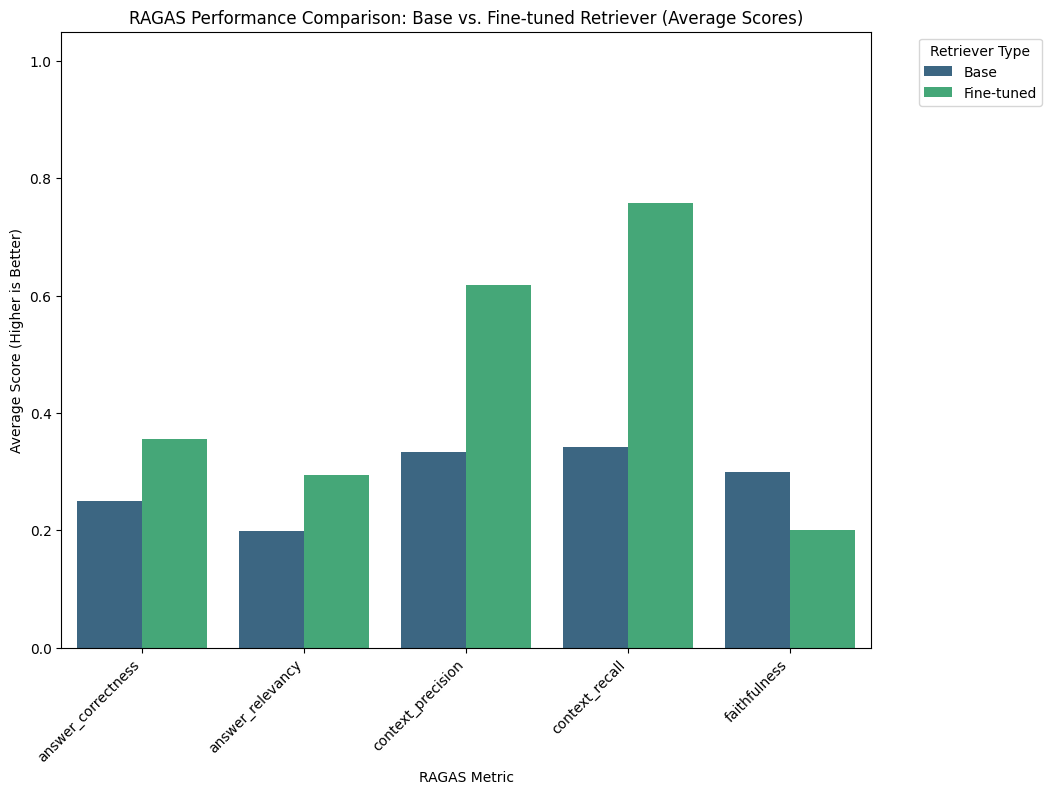

Plot generated.


In [92]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import traceback
from collections import defaultdict # Use defaultdict for easier aggregation

# --- Check if the score objects exist from the previous cell ---
plot_data = []
metrics_available = [] # To collect all unique metric names for consistent plotting order

print("Preparing data for plotting...")

# Function to safely extract AVERAGE scores from EvaluationResult's .scores list
def extract_average_scores(result_obj, label):
    global metrics_available # Allow modification of the global list
    average_scores = {} # Dictionary to hold the calculated average scores

    if result_obj is None:
        print(f"{label} scores object (result_obj) is None.")
        return average_scores # Return empty dict

    print(f"Processing {label} scores (input type: {type(result_obj)})...")

    # --- Access the .scores attribute, expecting a LIST ---
    scores_list = None
    if hasattr(result_obj, 'scores'):
        scores_attribute = result_obj.scores
        if isinstance(scores_attribute, list):
            scores_list = scores_attribute
            print(f"  Successfully accessed .scores attribute for {label} (found list with {len(scores_list)} items).")
        else:
             print(f"  Found .scores attribute for {label}, but it's not a list. Type: {type(scores_attribute)}")
    else:
         print(f"  Critical: Did not find expected '.scores' attribute for {label}.")

    # --- Aggregate scores from the list ---
    if scores_list:
        metric_sums = defaultdict(float)
        metric_counts = defaultdict(int)
        valid_samples_processed = 0

        print(f"  Aggregating scores from {len(scores_list)} samples...")
        for sample_scores in scores_list: # Iterate through list of score dicts
            if isinstance(sample_scores, dict):
                valid_samples_processed += 1
                for metric, score in sample_scores.items():
                    if isinstance(score, (int, float)) and pd.notna(score): # Check numeric and not NaN
                        metric_sums[metric] += score
                        metric_counts[metric] += 1
                        # Add metric to global list if not already present
                        if metric not in metrics_available:
                            metrics_available.append(metric)
                    # else: print(f"    Skipping non-numeric/NaN score for '{metric}' in sample.") # Optional debug
            # else: print(f"    Skipping non-dict item in scores list: {type(sample_scores)}") # Optional debug

        print(f"  Processed {valid_samples_processed} valid sample dictionaries.")

        # --- Calculate Averages ---
        print(f"  Calculating average scores for {label}...")
        for metric, total_sum in metric_sums.items():
            count = metric_counts.get(metric, 0)
            if count > 0:
                avg_score = total_sum / count
                average_scores[metric] = avg_score
                print(f"    Metric: {metric}, Average: {avg_score:.4f} (Sum: {total_sum}, Count: {count})")
            else:
                 print(f"    Metric: {metric}, Count was 0, skipping average calculation.")

    else:
        print(f"  Warning: Could not obtain a valid scores list for {label}.")

    if not average_scores:
        print(f"  Warning: No average scores could be calculated for {label}.")

    return average_scores # Return the dictionary of *average* scores


# --- Populate plot_data using the AVERAGE scores ---
base_avg_scores = extract_average_scores(globals().get('base_ragas_score'), 'Base')
finetune_avg_scores = extract_average_scores(globals().get('finetune_ragas_score'), 'Fine-tuned')

# Add average scores to plot_data
for metric, score in base_avg_scores.items():
    plot_data.append({'Metric': metric, 'Score': score, 'Retriever Type': 'Base'})

for metric, score in finetune_avg_scores.items():
     plot_data.append({'Metric': metric, 'Score': score, 'Retriever Type': 'Fine-tuned'})


# --- Create Plot (only if data was successfully processed) ---
if plot_data:
    print("\nGenerating plot...")
    plot_df = pd.DataFrame(plot_data)

    if not plot_df.empty:
        # Use the collected unique metrics for ordering
        if metrics_available:
            metrics_ordered = sorted(list(set(metrics_available)))
        else:
            metrics_ordered = sorted(list(set(plot_df['Metric'].unique())))

        plot_df_filtered = plot_df[plot_df['Metric'].isin(metrics_ordered)]

        if not plot_df_filtered.empty:
            plt.figure(figsize=(12, 8))
            sns.barplot(data=plot_df_filtered, x='Metric', y='Score', hue='Retriever Type', palette='viridis', order=metrics_ordered)

            plt.title('RAGAS Performance Comparison: Base vs. Fine-tuned Retriever (Average Scores)') # Updated title
            plt.ylabel('Average Score (Higher is Better)')
            plt.xlabel('RAGAS Metric')
            plt.ylim(0, 1.05)
            plt.xticks(rotation=45, ha='right')
            plt.legend(title='Retriever Type', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.subplots_adjust(right=0.80)
            plt.show()
            print("Plot generated.")
        else:
            print("Plotting skipped: No valid numeric data to plot after filtering.")
    else:
        print("Plotting skipped: DataFrame for plotting is empty.")
else:
    print("Plotting skipped: No valid data collected into plot_data list (check score extraction steps).")